![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Contrastive Learning
*By Paul Heinsohn Manetti - Gabriel Della Maggiora*

Implementation based on Tensorflow 2.6 using unsupervised learning for CIFAR-10 dataset

Reference:

Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020, November). [A simple framework for contrastive learning of visual representations](https://arxiv.org/pdf/2002.05709.pdf). In International conference on machine learning (pp. 1597-1607). PMLR.

## Imports

In [ ]:
import numpy as np
import seaborn as sns
from random import random, uniform
from matplotlib import pyplot as plt

from seaborn import heatmap
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm
from IPython.display import clear_output

### Drive path setup
Execute only if you want to manage your files with drive. However you won't be
able to load weights.

In [ ]:
!mkdir results

In [ ]:
BASE_PATH = '/content/results'

### Dropbox load weights
Execute if you don't have access to pre-trained weights.

Same model trained with the following params:
* batch_size = 256
* learning_rate = 1e-4
* train_steps = 50000

In [ ]:
!wget https://www.dropbox.com/s/0efojgr7kocd7es/nt_xent_weights_50000_steps.h5
#!wget https://www.dropbox.com/s/rw2gmnmwqirijd1/weights_contrastive_learning.h5

DROPBOX_WEIGHTS_PATH = "./nt_xent_weights_50000_steps.h5"
#DROPBOX_WEIGHTS_PATH = "weights_contrastive_learning.h5"

clear_output()
print("Weights downloaded.")

Weights downloaded.


## Utils

### Plotters

In [ ]:
CLASS_COLORS = ['black', 'red', 'green', 'blue', 'yellow',
                'purple', 'cyan', 'orange', 'pink', 'magenta']


def imshow(img):
  plt.imshow(img)
  plt.show()


def method_plot(method, name, h_pred, y_true, train_steps=-1, step=-1, save=0):
  df = method.fit_transform(h_pred)
  df_x = df[:, 0]
  df_y = df[:, 1]
  figure = plt.figure()
  ax = figure.add_subplot(111)

  for label in range(len(CLASS_COLORS)):
    indices = [i for i, l in enumerate(y_true) if l == label]
    current_x = np.take(df_x, indices, axis=0)
    current_y = np.take(df_y, indices, axis=0)
    color = CLASS_COLORS[label]

    ax.scatter(current_x, current_y, c=color,
                s=2.0, label=y_classes[label])

  ax.legend(loc="best")
  if save:
    #plt.savefig(f"{BASE_PATH}/{train_steps}_steps/imgs/{name}/step_{step}.png")
    plt.savefig(f"{BASE_PATH}/{train_steps}_steps_imgs_{name}_step_{step}.png")
    plt.close('all')
  else:
    plt.show()

### Metrics

In [ ]:
def save_clusters(train_steps, step, h_pred, y_true):
  pca = PCA(n_components=2)
  tsne = TSNE(n_components=2)
  method_plot(pca, 'PCA', h_pred, y_true, train_steps=train_steps, step=step, save=1)
  method_plot(tsne, 'TSNE', h_pred, y_true, train_steps=train_steps, step=step, save=1)


def print_pca(h_pred, y_true):
  pca = PCA(n_components=2)
  method_plot(pca, 'PCA', h_pred, y_true)


def print_tsne(h_pred, y_true):
  tsne = TSNE(n_components=2)
  method_plot(tsne, 'TSNE', h_pred, y_true)


def print_confusion(y_test, y_pred, show_heatmap=1, Cnorm=1):
  cnf_matrix = confusion_matrix(y_test, y_pred)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)

  TPR = list(map(lambda x: f"{round(x * 100, 2)}%", TPR))
  FPR = list(map(lambda x: f"{round(x * 100, 2)}%", FPR))

  print(f"TPR: {TPR}")
  print(f"FPR: {FPR}")
  if show_heatmap:
    sns.heatmap(cnf_matrix/Cnorm, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()


def evaluate(classifier, x_test, y_test):
  y_pred = classifier.predict(x_test)
  print("Evaluating Classifier...")
  print(f"Testing: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
  print_confusion(y_test, y_pred)

### Auxiliar Functions

In [ ]:
def sim_func_dim1(x, y):
  '''
  Cosine Similarity Function for 1D
  x shape: (N, 1, C)
  y shape: (N, C, 1)
  v shape: (N, 1, 1)
  '''
  v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
  return v


def sim_func_dim2(x, y):
  '''
  Cosine Similarity Function for 2D
  x shape: (N, 1, C)
  y shape: (1, C, 2N)
  v shape: (N, 2N)
  '''
  v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
  return v


def get_negative_mask(batch_size):
  '''
  Return a mask that removes the similarity score of equal/similar images.
  this function ensures that only distinct pair of images get their similarity
  scores passed as negative examples
  '''
  negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
  for i in range(batch_size):
      negative_mask[i, i] = 0
      negative_mask[i, i + batch_size] = 0
  return tf.constant(negative_mask)

## Dataset
Dataset to implement is CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

N_TRAIN = x_train_norm.shape[0]
N_TEST = x_test_norm.shape[0]
img_shape = x_test_norm[0].shape

y_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
                   'frog', 'horse', 'ship', 'truck']

print("Dataset cargado")

170508288/170498071 [==============================] - 2s 0us/step
Dataset cargado


### Augmentation

El primer paso es hacer **data augment** usando secuencialmente:
* Random crop + resize
* Random color distortion
* Random Gaussian blur



#### Random Crop + Resize + Flip

In [ ]:
box = np.array([0, 0, 1, 1])
boxes = box.reshape([1,1,4])

def random_crop_resize(img, echo=0):
  # Crops
  begin, size, _ = tf.image.sample_distorted_bounding_box(
    x_train[0].shape,
    bounding_boxes=boxes,
    area_range=[0.08, 1.0],
    use_image_if_no_bounding_boxes=True)

  random_crop = tf.slice(img, begin, size)

  # Resizes
  resize_crop = tf.image.resize(
      random_crop,
      (32, 32),
      method="nearest")

  # Flips
  flip_resize_crop = tf.image.random_flip_left_right(resize_crop)

  distorted_img = flip_resize_crop.numpy()
  if echo:
    imshow(distorted_img)

  return distorted_img

#### Random Color Distortion

In [ ]:
def _color_jitter(x, s=1.0):
  delta = 0.8 * s
  lower = 1 - delta
  upper = 1 + delta
  hue_delta = 0.2 * s
  x = tf.image.random_brightness(x, delta)
  x = tf.image.random_contrast(x, lower, upper)
  x = tf.image.random_saturation(x, lower, upper)
  x = tf.image.random_hue(x, hue_delta)
  x = tf.clip_by_value(x, 0, 1)
  return x

def _color_drop(x):
  x = tf.image.rgb_to_grayscale(x)
  x = tf.tile(x, [1, 1, 3])
  return x

def color_distortion(img, s=1.0, echo=0):
  if random() <= 0.8:
    img = _color_jitter(img, s)
  else:
    img = _color_drop(img)

  if echo:
    imshow(img)

  return img

#### Random Gaussian Blur

In [ ]:
def _gaussian_kernel(channels, kernel_size, sigma, dtype):
  x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
  g = tf.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
  g_norm2d = tf.pow(tf.reduce_sum(g), 2)
  g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
  g_kernel = tf.expand_dims(g_kernel, axis=-1)
  return tf.expand_dims(tf.tile(g_kernel, (1, 1, channels)), axis=-1)

def gaussian_blur(img, kernel_size=3, echo=0):
  sigma = uniform(0.1, 2.0)
  blur = _gaussian_kernel(tf.shape(img)[-1], kernel_size, sigma, img.dtype)
  blur_img = tf.nn.depthwise_conv2d(img[None], blur, [1, 1, 1, 1], "SAME")

  distorted = blur_img[0]
  if echo:
    imshow(distorted)
  return distorted

#### All Augment Methods

In [ ]:
def gen_augment_methods():
  while True:
    yield random_crop_resize
    yield color_distortion
    yield gaussian_blur


### Get Batch Data

In [ ]:
augment_methods = gen_augment_methods()

def get_batch(batch_size, x_train_batch, y_train_batch):
  x_train_odd = np.zeros((batch_size//2, *img_shape))
  x_train_even = np.zeros((batch_size//2, *img_shape))
  y_train_sample = np.zeros((batch_size//2,))
  for i in range(batch_size // 2):
    x_train_odd[i] = next(augment_methods)(x_train_batch[i])
    x_train_even[i] = next(augment_methods)(x_train_batch[i])
    y_train_sample[i] = y_train_batch[i]

  return x_train_odd, x_train_even, y_train_sample

## Contrastive Loss Function
Based on the following [github repository](https://github.com/sthalles/SimCLR) that's based on the same [paper](https://arxiv.org/pdf/2002.05709.pdf)

In [ ]:
def loss_f():
  sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.SUM)

  def loss_nt_xent(y_true, y_pred):
    '''
    Use of y_true as Mask, because we dont want the similarity between
    same elements, so we call get_negative_mask during training and pass it
    as y_true
    '''
    tau = 0.5

    z_i = y_pred[..., 0]
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = y_pred[..., 1]
    z_j = tf.math.l2_normalize(z_j, axis=1)

    batch_size = tf.keras.backend.shape(z_i)[0]

    l_pos = sim_func_dim1(z_i, z_j)
    l_pos = tf.squeeze(l_pos, axis=-1) / tau

    negatives = tf.concat([z_j, z_i], axis=0)

    loss = 0
    mask=y_true
    for positives in [z_i, z_j]:
      l_neg = sim_func_dim2(positives, negatives)

      labels = tf.zeros(batch_size, dtype=tf.float32)

      l_neg = tf.boolean_mask(l_neg, mask)
      l_neg = tf.reshape(l_neg, (batch_size, -1))
      l_neg /= tau

      # assert l_neg.shape == (
      #   batch_size, 2 * (batch_size - 1)), "Shape of negatives not expected." + str(
      #   l_neg.shape)
      logits = tf.concat([l_pos, l_neg], axis=1)  # [N,K+1]
      loss += sparse_loss(y_pred=tf.cast(logits, dtype=tf.float32),
                          y_true=tf.cast(labels, dtype=tf.float32))

    loss = loss / (2 * tf.cast(batch_size, dtype=tf.float32))
    return loss

  return loss_nt_xent

## Models

In [ ]:
def create_f_model(img_shape=(32, 32, 3)):
  base_model = tf.keras.applications.resnet50.ResNet50(weights="imagenet", classes=10, include_top=False)
  input_ = tf.keras.Input(shape=img_shape)
  out = base_model(input_)
  out = tf.keras.layers.GlobalAveragePooling2D()(out)
  return tf.keras.Model(inputs=input_, outputs=out)


def create_g_model():
  base_model = tf.keras.models.Sequential()
  base_model.add(tf.keras.Input(shape=(2048,)))
  base_model.add(tf.keras.layers.Dense(128, activation="relu"))
  return base_model


def train_model(f_net, g_net, img_shape=(32, 32, 3)):
  input_xk_odd = tf.keras.layers.Input(shape=img_shape)
  h_odd = f_net(input_xk_odd)
  g_odd = tf.expand_dims(g_net(h_odd), axis=-1)

  input_xk_even = tf.keras.layers.Input(shape=img_shape)
  h_even = f_net(input_xk_even)
  g_even = tf.expand_dims(g_net(h_even), axis=-1)

  out = tf.keras.layers.Concatenate()([g_odd, g_even])

  # Return out, h_even, h_odd for using h as feature extractor in testing
  model = tf.keras.models.Model([input_xk_odd, input_xk_even], [out, h_even, h_odd])
  model.summary()
  return model


def load_model(weights_path, learning_rate=1e-4, img_shape=(32, 32, 3)):
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  f_model = create_f_model(img_shape)
  g_model = create_g_model()
  t_model = train_model(f_model, g_model, img_shape)
  t_model.compile(loss=loss_f(), optimizer=opt)
  t_model.load_weights(weights_path)
  print("Model loaded successfully.")
  return t_model


## Training + Testing

### Constants

In [ ]:
batch_size = 256
train_steps = 50000
learning_rate = 1e-4

### Training
Run only if you want new data

(execution: 12 hours approx)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
f_model = create_f_model(img_shape)
g_model = create_g_model()
t_model = train_model(f_model, g_model, img_shape)
# Compile with mae = 0 to avoid influence of h_odd and h_even in loss value
t_model.compile(loss=[loss_f(), 'mae', 'mae'],
                loss_weights=[1, 0, 0], optimizer=opt)

pbar = tqdm(range(train_steps))
for step in pbar:
    ix = np.random.randint(0, x_train_norm.shape[0], batch_size)
    x_train_batch = x_train_norm[ix]
    x_train_odd, x_train_even, _ = get_batch(
        batch_size, x_train_batch, y_train[ix])

    mask = tf.cast(get_negative_mask(batch_size//2), dtype=tf.float32)

    # Pass a matrix of 0's for both unused losses
    loss_out = t_model.train_on_batch([x_train_odd, x_train_even], [mask, np.zeros(
        (batch_size//2, 2048)), np.zeros((batch_size//2, 2048))])

    pbar.set_postfix({'loss': np.round(loss_out, decimals=5)})

    # Every 500 steps, save weights and imgs
    if step % 500 == 0:
        x_test_odd, x_test_even, y_train_sample = get_batch(
            batch_size, x_test_norm, y_test)

        pred_out, pred_h_odd, pred_h_even = t_model.predict(
            [x_test_odd, x_test_even])

        pred_h = np.concatenate([pred_h_odd, pred_h_even], axis=0)
        y_h = np.concatenate([y_train_sample, y_train_sample], axis=0)

        save_clusters(train_steps, step, pred_h, y_h)
        #t_model.save_weights(f"{BASE_PATH}/{train_steps}_steps/weights/my_weights_{step}.h5")
        t_model.save_weights(f"{BASE_PATH}/{train_steps}_steps_weights_my_weights_{step}.h5")

#t_model.save_weights(f"{BASE_PATH}/weights/final_weights.h5")
t_model.save_weights(f"{BASE_PATH}/weights_final_weights.h5")

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)    

100%|██████████| 50000/50000 [12:09:51<00:00,  1.14it/s, loss=[4.02093 4.02093 0.29399 0.29272]]


### Testing

#### Load Model + Predict
You can load from local path to weights or from dropbox

In [ ]:
# t_model = load_model(f"{BASE_PATH}/50000_steps/weights/final_weights.h5", learning_rate, img_shape)
#WEIGHTS_PATH = DROPBOX_WEIGHTS_PATH
WEIGHTS_PATH = f"{BASE_PATH}/weights_final_weights.h5"
t_model = load_model(WEIGHTS_PATH, learning_rate, img_shape)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 2048)         23587712    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          262272      model_2[0][0]              

Predictions for a random batch

In [ ]:
test_batch = 4096
x_test_odd, x_test_even, y_test_sample = get_batch(test_batch, x_test_norm, y_test)

pred_out, pred_h_odd, pred_h_even = t_model.predict([x_test_odd, x_test_even])

h_pred_test = np.concatenate([pred_h_odd, pred_h_even], axis=0)
y_true_test = np.concatenate([y_test_sample, y_test_sample], axis=0)

clear_output()
print("Predictions made")

Predictions made


#### PCA + TSNE Plot
Plot the predictions in the feature space using PCA and T-SNE methods

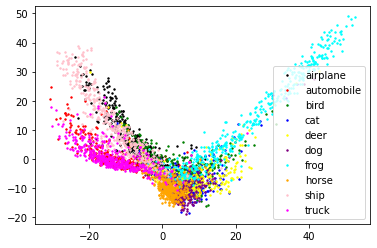

In [ ]:
print_pca(h_pred_test, y_true_test)

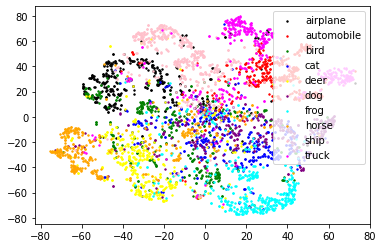

In [ ]:
# This may take a while
print_tsne(h_pred_test, y_true_test)

### KNN Implementation
Comparison between two KNNs with 50 neighbors:
1. Trained with images, this is just using pixels and rgb channels
2. Trained with the learned h function

In [ ]:
n_neighbors = 50

##### Using image pixels

Fitting model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Evaluating Classifier...
Testing: 32.39%
TPR: ['49.4%', '11.0%', '41.2%', '10.0%', '61.1%', '20.1%', '28.7%', '16.5%', '72.7%', '13.2%']
FPR: ['5.98%', '0.28%', '15.52%', '2.02%', '25.0%', '2.09%', '7.09%', '0.88%', '15.53%', '0.73%']


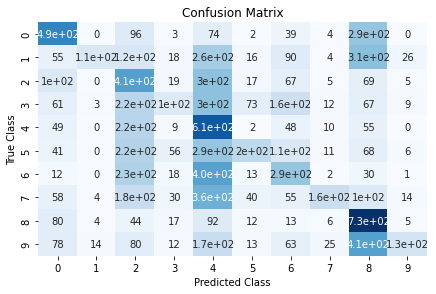

In [ ]:
# This may take a while
def KNN_classify_pixels(x_train, y_train, x_test, y_test, n_neighbors=50, img_shape=(32, 32, 3)):
    # Flatten
    n_features = np.prod(img_shape)
    f_train = x_train.reshape(x_train.shape[0], n_features)
    f_test = x_test.reshape(x_test.shape[0], n_features)

    # Fit
    print("Fitting model...")
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(f_train, y_train)

    evaluate(classifier, f_test, y_test)
    return classifier

KNN_pixel_classifier = KNN_classify_pixels(x_train_norm, y_train, x_test_norm, y_test, n_neighbors, img_shape)

##### Using h function

In [ ]:
# Get h_train values
x_train_odd, x_train_even, y_train_sample = get_batch(N_TRAIN, x_train_norm, y_train)
train_out, h_train_odd, h_train_even = t_model.predict([x_train_odd, x_train_even])
h_pred_train = np.concatenate([h_train_odd, h_train_even], axis=0)
y_true_train = np.concatenate([y_train_sample, y_train_sample], axis=0)

# Get h_test values
x_test_odd, x_test_even, y_test_sample = get_batch(N_TEST, x_test_norm, y_test)
test_out, h_test_odd, h_test_even = t_model.predict([x_test_odd, x_test_even])
h_pred_test = np.concatenate([h_test_odd, h_test_even], axis=0)
y_true_test = np.concatenate([y_test_sample, y_test_sample], axis=0)

In [ ]:
# Fit KNN
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(h_pred_train, y_true_train)

clear_output()
print("KNN fitted")

KNN fitted


Testing: 0.7341
TPR: ['78.38%', '85.15%', '59.86%', '60.56%', '71.79%', '55.02%', '81.77%', '76.87%', '81.25%', '83.14%']
FPR: ['2.93%', '1.5%', '2.4%', '7.16%', '3.53%', '3.38%', '2.72%', '2.12%', '1.27%', '2.54%']


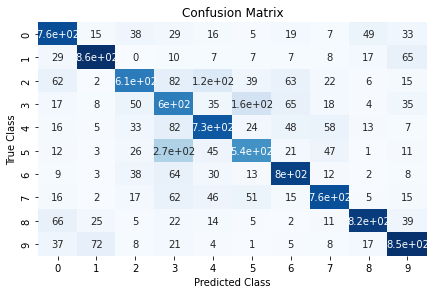

In [ ]:
# Test KNN
y_pred = classifier.predict(h_pred_test)
print(f"Testing: {accuracy_score(y_true_test, y_pred)}")
print_confusion(y_true_test, y_pred)